In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.optimize as op
import scipy as sc

# Runge-Kutta

In [2]:
def rk4(f,x,t,h):
    h2=0.5*h
    for i in range(1,len(t)):
        k1= h*f(t[i-1],x[i-1])
        k2= h*f(t[i-1]+h2,x[i-1]+0.5*k1); k3= h*f(t[i-1]+h2, x[i-1]+0.5*k2); k4= h*f(t[i-1]+h,x[i-1]+k3)
        x[i]= x[i-1]+(k1+2*(k2+k3)+k4)/6 
    return x 

## Oscilador anarmonico - Primer modelo

In [3]:
def OscAnar1(Integrador,Cnste_Elastica,Masa,Amplitud,Desfase,alpha,to,tf,h,Graficas=False):
    k= Cnste_Elastica ; m= Masa ; A= Amplitud ; phi= Desfase ; w= np.sqrt(k/m)
    
    #Condiciones iniciales 
    xo=np.array([A*np.cos(phi),-A*w*np.sin(phi)])
    
    if alpha !=0 and 0.5*( m*xo[1]**2+(k*xo[0]**2 *(1-(2/3)*alpha*xo[0])) ) >= k/(6*alpha**2): 
        return 0.0, "Error pasó separatrix"
    
    if alpha*xo[0] > 1 or alpha*xo[0] < 0: return 0.0, "No existe fuerza restaurativa, Movimiento traslacional"
    
    n=int((tf-to)/h) ; t=np.linspace(to,tf,n) ; x=np.zeros([len(t),2]) ; x[0]=xo
    
    #Función vectorial de derivadas (dx/dt, dv/dt)
    def dYdt(t,y,w=w,alpha=alpha): return np.array([y[1],-w**2 *y[0]*(1-alpha*y[0])]) 
    
    #Funcion para encontrar el periodo 
    def periodo(z,t):
        top=[] ;  periodos=[]
        for i in range(1,len(t)):
            if z[i,0]*z[i-1,0] < 0: to= 0.5*(t[i-1] + t[i]) ; top= np.hstack((top,to))    
             
        for i in range(len(top)-2): Tp= top[i+2]-top[i] ; periodos = np.hstack((periodos,Tp))
            
        if len(periodos) < 1: return 0.0, "No suficientes tiempo, para encontrar el periodo"  
        
        return periodos.mean(), periodos.std()
    
    Y=Integrador(dYdt,x,t,h)  #posiciones y velocidades    
    T=periodo(Y,t)
    
    # Energia Mecanica del sistema
    K= 0.5*m*(Y[:,1]**2)  ;  V= (0.5*k*(Y[:,0]**2 ) )* (1-(2/3)*alpha*Y[:,0])  ;  ET= K + V
    
    if Graficas != False:
        plt.plot(t,Y[:,0],t,Y[:,1]), plt.legend(("Posición","Velocidad")), plt.grid(),plt.xlabel("Tiempo")
        plt.title("Vector dinámico vs tiempo, Modelo 1"),plt.ylabel("Y (t)");plt.show() # grafica 1
    
        plt.plot(t,ET,"k--",t,K,t,V,),plt.legend(("E-total","K","V")), plt.grid(),plt.xlabel("Tiempo") 
        plt.title("Energías vs tiempo, Modelo 1"),plt.ylabel("Energía");plt.show() #grafica 2
    
        plt.plot(Y[:,0],V,label="V(x) vs x"),plt.xlim(-2*A,2*A), plt.legend(),plt.grid()
        plt.xlabel("x"); plt.title("Pozo de potencial, Modelo 1"),plt.ylabel("V(x)");plt.show() #grafica 3
        
    if alpha != 0: E_alpha= k/(6*alpha**2) 
    else: E_alpha="Movimiento armonico"
    return "Periodo = ",T,"Posiciones(t) = ",Y[:,0],"Velocidades(t) = ",Y[:,1],"Energia inicial = ",ET[0],\
                                "Energia para separatrix =",E_alpha

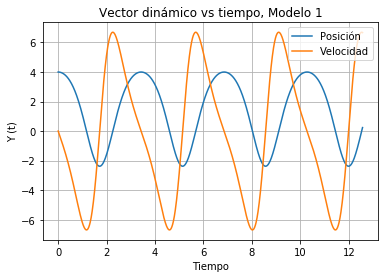

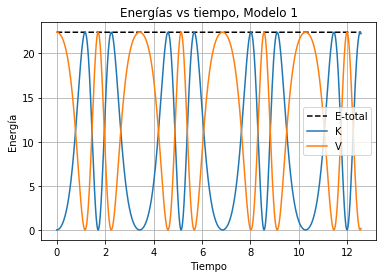

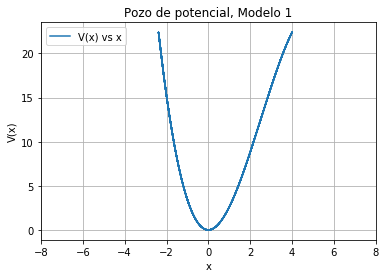

('Periodo = ',
 (3.426129996185841, 0.0037316412913893336),
 'Posiciones(t) = ',
 array([4.        , 3.99975999, 3.99903988, ..., 0.10357476, 0.17042333,
        0.23717323]),
 'Velocidades(t) = ',
 array([-0.        , -0.04800288, -0.09602304, ...,  6.68853664,
         6.68054601,  6.66882043]),
 'Energia inicial = ',
 22.4,
 'Energia para separatrix =',
 24.999999999999996)

In [4]:
OscAnar1(rk4,6,1,4,0,0.2,0,4*np.pi,1e-2,Graficas=1) #6,1,2,0.2

In [12]:
def Graficas_amplitudes_M1(to,tf,h,A1=0.5,A2=3,A3=4.9,phi=0,alpha=0.2):
    n=int((tf-to)/h)  ;  t=np.linspace(to,tf,n)
    g1=OscAnar1(rk4,6,1,A1,phi,alpha,to,tf,h)   ;   g2=OscAnar1(rk4,6,1,A2,phi,alpha,to,tf,h)
    g3=OscAnar1(rk4,6,1,A3,phi,alpha,to,tf,h)
    #plt.plot(x,c,"yo")
    plt.plot(t,g1[3],linewidth=3)     ;   plt.plot(t,g2[3],"r-.",linewidth=2)
    plt.plot(t,g3[3],"k--",linewidth=1)
    plt.legend(("A1","A2","A3")),plt.grid(),plt.xlabel("Tiempo"),plt.ylabel("Posicion (t)")
    plt.title("Dependencia de la amplitud, alpha=0.2");plt.show()
    
    return "T1=",g1[1][0],"T2=",g2[1][0],"T3=",g3[1][0]

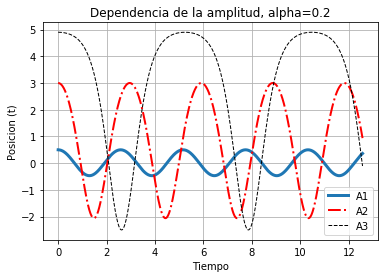

('T1=', 2.578358910914332, 'T2=', 2.952179231978935, 'T3=', 5.236822176342508)

In [13]:
Graficas_amplitudes_M1(0,4*np.pi,1e-2)

In [16]:
def P_Am_M1(Ao,Af,particiones,to=0,tf=4*np.pi,h=1e-2,alpha=0.2,k=6,m=1):
    #observación 
    Amplitudes=np.linspace(Ao,Af,particiones)   ;  Periodos=[]
    for i in range(len(Amplitudes)):
        A= Amplitudes[i] ; p=OscAnar1(rk4,k,m,A,0,alpha,to,tf,h)[1][0] ; Periodos= np.hstack((Periodos,p))
        
    #Ajuste
    def f(x,a,b,c,d,e): return  d*np.exp(x**2/c) + e*np.exp(x/a) + b
    data=op.curve_fit(f,Amplitudes,Periodos) ; a,b,c,d,e=data[0] ; sigma=np.sqrt(np.diag(data[1]))
    
    chiq=sum( (Periodos-f(Amplitudes,a,b,c,d,e))**2 ) ; af=np.array([a,sigma[0]]) ; bf=np.array([b,sigma[1]])
    cf= np.array([c,sigma[2]]); df= np.array([d,sigma[3]])  ; ef= np.array([e,sigma[4]]) 
    
    
    #grafica
    plt.plot(Amplitudes,Periodos,"k."), plt.plot(Amplitudes,f(Amplitudes,a,b,c,d,e))
    plt.grid(), plt.title("Periodo vs Amplitud, Modelo 1"),plt.xlabel("Amplitud (A)"),plt.ylabel("Periodo (T)")
    plt.legend(("T vs A","T(x) = d $e^{x^{2}/c}$+  n $e^{x/a}$ + b"));plt.savefig("TvsA-1-FT.eps");plt.show()  
    
    return "chiq=",chiq,"a=",af,"b=",bf ,"c=",cf,"d=",df,"e=",ef

### Con k=6 y m=1 

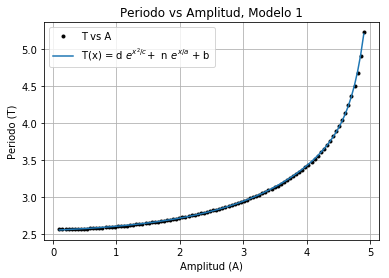

('chiq=',
 0.003371415472836265,
 'a=',
 array([1.38476856, 0.01126862]),
 'b=',
 array([2.50446488, 0.00253234]),
 'c=',
 array([1.82448626, 0.03287085]),
 'd=',
 array([1.84389766e-06, 4.50128449e-07]),
 'e=',
 array([0.05068699, 0.0012468 ]))

In [17]:
P_Am_M1(0.1,4.9,100,h=1e-3)

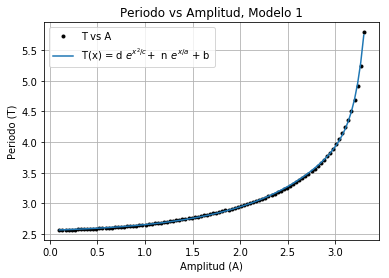

('chiq=',
 0.01467871671499386,
 'a=',
 array([0.86954215, 0.01098971]),
 'b=',
 array([2.5182019 , 0.00440738]),
 'c=',
 array([0.62605851, 0.01549925]),
 'd=',
 array([3.71521534e-08, 1.62310557e-08]),
 'e=',
 array([0.04264269, 0.00180674]))

In [18]:
P_Am_M1(0.1,3.3,100,alpha=0.3,h=1e-3,tf=5*np.pi) #k=6 ,m=1

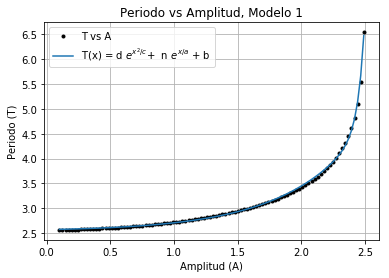

('chiq=',
 0.055342250723023005,
 'a=',
 array([0.5967404, 0.0107908]),
 'b=',
 array([2.54024798, 0.00699248]),
 'c=',
 array([0.24178922, 0.00796017]),
 'd=',
 array([1.36118988e-11, 1.15525226e-11]),
 'e=',
 array([0.03188661, 0.00218865]))

In [19]:
P_Am_M1(0.1,2.49,100,alpha=0.4,h=1e-3) #k=6 ,m=1 

### Con k=7 y m=2

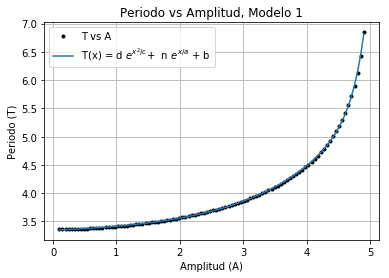

('chiq=',
 0.0057605704261254964,
 'a=',
 array([1.38449889, 0.01124879]),
 'b=',
 array([3.27924832, 0.00330947]),
 'c=',
 array([1.82493009, 0.0328446 ]),
 'd=',
 array([2.42104742e-06, 5.90293090e-07]),
 'e=',
 array([0.0663255, 0.0016291]))

In [20]:
P_Am_M1(0.1,4.9,100,k=7,m=2,tf=5*np.pi,h=1e-3)

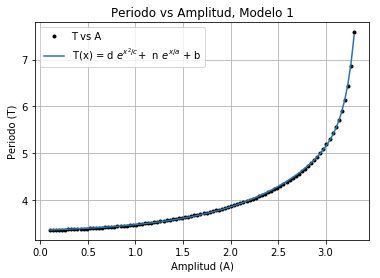

('chiq=',
 0.025280572374602638,
 'a=',
 array([0.86931777, 0.01100575]),
 'b=',
 array([3.297168  , 0.00578094]),
 'c=',
 array([0.62570469, 0.01552811]),
 'd=',
 array([4.81591720e-08, 2.11045303e-08]),
 'e=',
 array([0.0557889 , 0.00236849]))

In [21]:
P_Am_M1(0.1,3.3,100,k=7,m=2,tf=5*np.pi,h=1e-3,alpha=0.3)

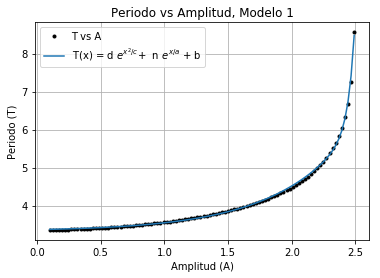

('chiq=',
 0.09484584282349072,
 'a=',
 array([0.59662508, 0.01078507]),
 'b=',
 array([3.32596711, 0.00915136]),
 'c=',
 array([0.24173883, 0.00796038]),
 'd=',
 array([1.77212222e-11, 1.50472820e-11]),
 'e=',
 array([0.0417189, 0.0028631]))

In [22]:
P_Am_M1(0.1,2.49,100,k=7,m=2,tf=6*np.pi,h=1e-3,alpha=0.4)

### Con k=4 y m=1 

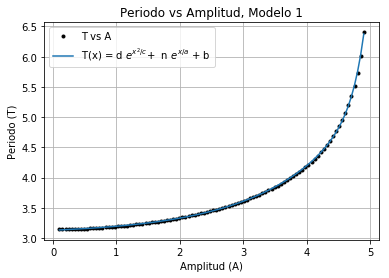

('chiq=',
 0.005064824016526922,
 'a=',
 array([1.38473709, 0.01127524]),
 'b=',
 array([3.06732602, 0.00310358]),
 'c=',
 array([1.82425452, 0.03289738]),
 'd=',
 array([2.25401835e-06, 5.50860022e-07]),
 'e=',
 array([0.06207657, 0.00152796]))

In [23]:
P_Am_M1(0.1,4.9,100,h=1e-3,k=4,m=1) 

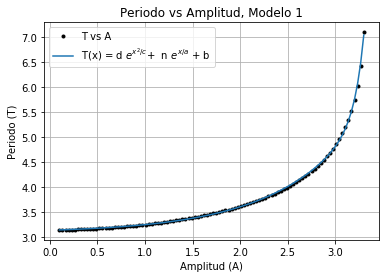

('chiq=',
 0.021915069662405636,
 'a=',
 array([0.86950181, 0.01096895]),
 'b=',
 array([3.08418125, 0.00538599]),
 'c=',
 array([0.62649896, 0.01548227]),
 'd=',
 array([4.60475238e-08, 2.00686118e-08]),
 'e=',
 array([0.05221477, 0.00220811]))

In [24]:
P_Am_M1(0.1,3.3,100,alpha=0.3,h=1e-3,tf=5*np.pi,k=4,m=1)

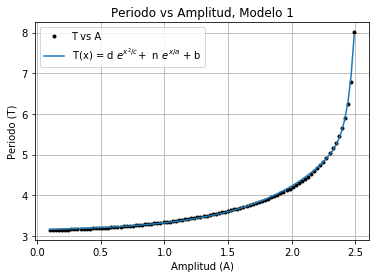

('chiq=',
 0.08335479724173199,
 'a=',
 array([0.59654284, 0.0108029 ]),
 'b=',
 array([3.11133569, 0.00857669]),
 'c=',
 array([0.24161195, 0.00797333]),
 'd=',
 array([1.63553599e-11, 1.39208332e-11]),
 'e=',
 array([0.03900729, 0.00268223]))

In [25]:
P_Am_M1(0.1,2.49,100,alpha=0.4,h=1e-3,tf=5*np.pi,k=4,m=1)

# b

In [26]:
t6=(2*np.pi)/(np.sqrt(6/1)) #B 0,2 0,3 0,4 k=6 y m=1
b2=2.50446488; b3=2.5182019 ; b4=2.54024798
b2/t6, b3/t6, b4/t6

(0.9763616278690412, 0.9817169831452829, 0.9903116121731537)

In [27]:
t7=(2*np.pi)/(np.sqrt(7/2)) #B 0,2 0,3 0,4 k=7 y m=2
bb2=3.27924832; bb3=3.297168 ; bb4=3.32596711
bb2/t7, bb3/t7, bb4/t7

(0.976401546328239, 0.9817371603331299, 0.9903121424000192)

In [28]:
t4=(2*np.pi)/(np.sqrt(4/1)) #B 0,2 0,3 0,4 k=4 y m=1
bbb2=3.06732602; bbb3=3.08418125 ; bbb4=3.11133569
bbb2/t4, bbb3/t4, bbb4/t4

(0.9763601963147797, 0.9817253826576813, 0.9903689093634659)

array([0.96206551, 0.07100986])

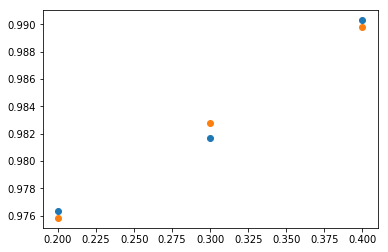

In [29]:
h2=np.array([b2/t6,b3/t6,b4/t6]) ; al=np.array([0.2,0.3,0.4])
def cre(x,a,b): return a* np.exp(b*x)
fit=op.curve_fit(cre,al,h2); a,b=fit[0]
plt.plot(al,h2,"o")
plt.plot(al,cre(al,a,b),"o")
fit[0]

# A y C

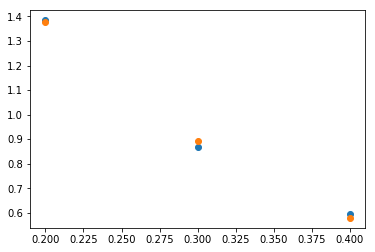

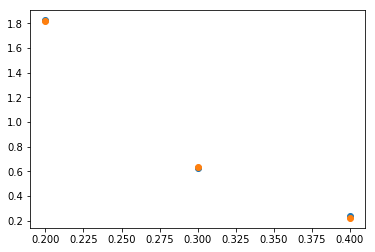

(array([ 3.27717296, -4.33490086]), array([ 14.83858314, -10.48549767]))

In [30]:
a6_2=1.38476856; c6_2= 1.82448626
a6_3=0.86954215; c6_3= 0.62605851
a6_4=0.5967404; c6_4= 0.24178922

a7_2=1.38449889; c7_2= 1.82493009
a7_3=0.86931777; c7_3= 0.62570469
a7_4=0.59662508; c7_4= 0.24173883

a4_2=1.38473709; c4_2= 1.82425452
a4_3=0.86950181; c4_3= 0.62649896
a4_4=0.59654284; c4_4= 0.24161195

A_2= (a6_2+ a4_2+ a7_2)/3 ; C_2= (c6_2+ c7_2+c4_2)/3
A_3= (a6_3+ a4_3+ a7_3)/3 ; C_3= (c6_3+ c7_3+c4_3)/3
A_4= (a6_4+ a4_4+ a7_4)/3 ; C_4= (c6_4+ c7_4+c4_4)/3

#print(A_2,A_3,A_4), print(C_2,C_3,C_4)

ap=np.array([A_2,A_3,A_4]); cp=np.array([C_2,C_3,C_4])
fil=op.curve_fit(cre,al,ap); a,b=fil[0]
plt.plot(al,ap,"o");plt.plot(al,cre(al,a,b),"o") 
plt.show()
fill=op.curve_fit(cre,al,cp); ac,bc=fill[0]
plt.plot(al,cp,"o");plt.plot(al,cre(al,ac,bc),"o")  
plt.show()
np.array([a,b]), np.array([ac,bc])

# e

(array([ 0.02315185, -3.82722108]), array([0.00044244, 0.20935084]))

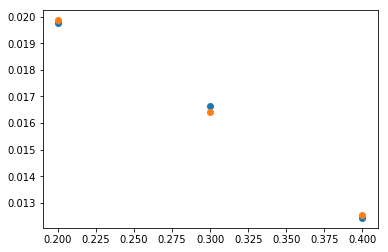

In [163]:
e6_2=0.05068699 ; e6_3=0.04264269 ; e6_4=0.03188661 #0,2 0,3 0,4 k=6 y m=1
e4_2=0.06207657 ; e4_3=0.05221477 ; e4_4=0.03900729 #0,2 0,3 0,4 k=4 y m=1
e7_2=0.0663255 ; e7_3=0.0557889 ; e7_4=0.0417189 #0,2 0,3 0,4 k=7 y m=2
#print(e6_2/t6, e6_3/t6, e6_4/t6)
#print(e4_2/t4, e4_3/t4, e4_4/t4)
#print(e7_2/t7, e7_3/t7, e7_4/t7)
kl=np.array([e6_2/t6, e6_3/t6, e6_4/t6])
def rec(x,a,b): return a*np.exp(b*x**2)
fit=op.curve_fit(rec,al,kl); a,b=fit[0]
plt.plot(al,kl,"o")
plt.plot(al,rec(al,a,b),"o")
fit[0], np.sqrt(np.diag(fit[1]))

# d

(array([1.30312656e-13, 9.64530741e+00]),
 array([3.20723372e-14, 1.52935469e-01]))

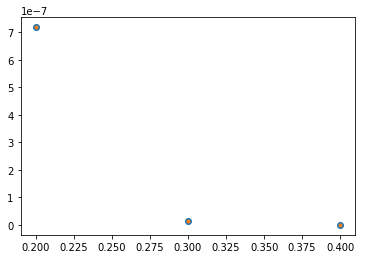

In [32]:
d6_2=1.84389766e-06 ; d6_3=3.71521534e-08 ; d6_4=1.36118988e-11
d4_2=2.25401835e-06 ; d4_3=4.60475238e-08 ; d4_4=1.63553599e-11
d7_2=2.42104742e-06 ; d7_3=4.81591720e-08 ; d7_4=1.77212222e-11
#print(d6_2/t6, d6_3/t6, d6_4/t6)
#print(d4_2/t4, d4_3/t4, d4_4/t4)
#print(d7_2/t7, d7_3/t7, d7_4/t7)
d_2=(d6_2/t6 + d4_2/t4 + d7_2/t7)/3
d_3=(d6_3/t6 + d4_3/t4 + d7_3/t7)/3
d_4=(d6_4/t6 + d4_4/t4 + d7_4/t7)/3
j=np.array([d_2, d_3, d_4])
def rer(x,a,b): return a*x**(-b)
fit=op.curve_fit(rer,al,j); a,b=fit[0]
plt.plot(al,j,"o")
plt.plot(al,rer(al,a,b),".")
fit[0], np.sqrt(np.diag(fit[1]))


In [178]:
def Apox_M1_2(alpha,k,m,A):
    to=(2*np.pi)/(np.sqrt(k/m))
    a1=0.96206551; b1=0.07100986 ;                         b=a1*np.exp(b1*alpha)
    a2=3.27717296; b2= -4.33490086 ;                       a=a2*np.exp(b2*alpha)
    a3=14.83858314; b3=-10.48549767;                       c=a3*np.exp(b3*alpha)
    a4=0.02315185; b4=-3.82722108;                         e=a4*np.exp(b4* alpha**2)
    a5=1.30312656e-13;b5= 9.64530741;                      d=a5*alpha**(-b5)
    return (d*np.exp((A**2)/c) + e*np.exp(A/a) + b)* to

In [185]:
alpha=0.2 ; k=6 ; m=5 ; A=4.55
Apox_M1_2(alpha,k,m,A), OscAnar1(rk4,k,m,A,0,alpha,0,4*np.pi,1e-2)[1][0]

(9.052743750522232, 9.021752927121604)

In [35]:
c2=4.22371932; c3=2.92838571; c4=2.44003942 # 0.2, 0,3, 0,4 - k=6,m=1
print(c2-c3, c3-c4, c2-c4 ) #alpha
#c2-ccc2,ccc2-cc2,c2-cc2 #periodo
ar2=c2/(t6/0.2);ar3=c3/(t6/0.3);ar4=c4/(t6/0.4) 
ar2-ar3, ar3-ar4, ar2-ar4, t6/(3*0.2), t6/(3*0.3), t6/(3*0.4)
t6/(0.2*c2), t6/(0.3*c3), t6/(0.4*c4)

1.2953336099999997 0.48834628999999996 1.7836798999999997


(3.036541334763372, 2.9198107926428496, 2.628133422045009)

In [36]:
to=t6;alpha=0.2;x=to/alpha;mf=2.06427922;cf= -0.57357665; mg=2.49750626 ;cg=-0.60745661; mj=1.14566225; cj=-0.05353341
(mg* to**cg )*(mj*to**(cj))**x + mf*(alpha**cf)*(1.2-2*alpha)**x
#to=t4; alpha=0.4
#( (2.15787867)*((to)**(-0.69389621)) )* (alpha)**(-(0.60176868* (to)**0.32827483))

4.519175683182742

In [37]:
cc2=3.95426804; cc3=2.65891265; cc4=2.17049083 # 0.2, 0,3, 0,4 - k=7,m=2
print(cc2-cc3, cc3-cc4, cc2-cc4)
#c3-ccc3, ccc3-cc3, c3-cc3
arr2=cc2/(t7/0.2);arr3=cc3/(t7/0.3);arr4=cc4/(t7/0.4)
arr2-arr3, arr3-arr4, arr2-arr4, t7/(4*0.2), t7/(4*0.3), t7/(4*0.4)
t7/(0.2*cc2), t7/(0.3*cc3), t7/(0.4*cc4)

1.29535539 0.4884218200000001 1.7837772100000002


(4.246682044251896, 4.210372507881405, 3.8683690461910727)

In [38]:
ccc2=4.02102561;ccc3=2.72579014 ;ccc4=2.23722059 # 0.2, 0,3, 0,4 - k=4,m=1
print(ccc2-ccc3, ccc3-ccc4, ccc2-ccc4)
#c4-ccc4, ccc4-cc4, c4-cc4
arrr2=ccc2/(t4/0.2); arrr3=ccc3/(t4/0.3);arrr4= ccc4/(t4/0.4)
arrr2-arrr3, arrr3-arrr4, arrr2-arrr4, t4/(4*0.2), t4/(4*0.3), t4/(4*0.4)
t4/(0.2*ccc2), t4/(0.3*ccc3), t4/(0.4*ccc4)

1.2952354699999997 0.4885695499999998 1.7838050199999995


(3.906456907134438, 3.841812822745766, 3.51059777881558)

t6 1.1220959944472177 0.8199467145198439
t4 0.9765710233672455 0.8758473279983173
t7 0.9298256908638048 0.8959754121322322


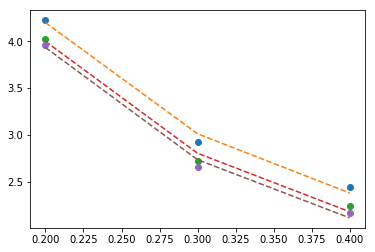

In [42]:
p1= [c2,c3,c4];p3=[cc2,cc3,cc4];p2=[ccc2,ccc3,ccc4];ppp=np.array([0.2,0.3,0.4])

def ffg(x,z,zz): return z* x**-zz
ki=op.curve_fit(ffg,ppp,p1); z1,zz1=ki[0]
ki2=op.curve_fit(ffg,ppp,p2); z2,zz2=ki2[0]
ki3=op.curve_fit(ffg,ppp,p3); z3,zz3=ki3[0]
plt.plot(ppp,p1,"o")
plt.plot(ppp,ffg(ppp,z1,zz1),"--")
plt.plot(ppp,p2,"o")
plt.plot(ppp,ffg(ppp,z2,zz2),"--")
plt.plot(ppp,p3,"o")
plt.plot(ppp,ffg(ppp,z3,zz3),"--")
print("t6",z1,zz1)
print("t4",z2,zz2)
print("t7",z3,zz3)


z [2.15787867 0.69389621] [0.02124925 0.0090593 ]


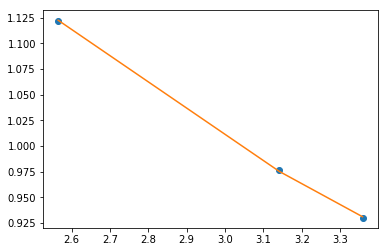

zz [0.60176868 0.32827483] [0.00207577 0.00309786]


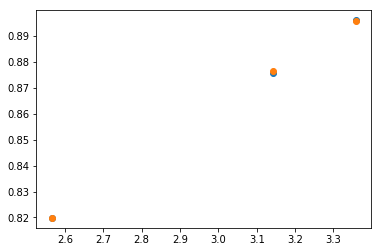

In [43]:
co=np.array([1.1220959944472177,0.9765710233672455,0.9298256908638048]) ; per=np.array([t6,t4,t7])
def ffg(x,m,b): return m* x**-b
def ffg2(x,m,b): return m* x**b
ke=op.curve_fit(ffg,per,co); m,b=ke[0]
ke2=op.curve_fit(ffg2,per,co2); m2,b2=ke2[0]
print("z",ke[0],np.sqrt(np.diag(ke[1])))
plt.plot(per,co,"o")
plt.plot(per,ffg(per,m,b)); plt.show()

print("zz",ke2[0],np.sqrt(np.diag(ke2[1])))
plt.plot(per,co2,"o")
plt.plot(per,ffg2(per,m2,b2),"o"); plt.show()

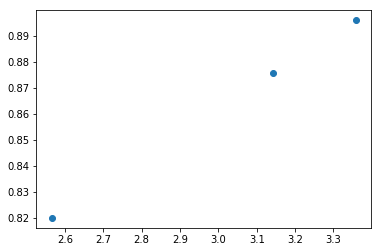

In [44]:
co2=np.array([0.8199467145198439,0.8758473279983173,0.8959754121322322]) ;  per=np.array([t6,t4,t7])
def ffg(x,m,b): return m* np.exp(b*x)
ke2=op.curve_fit(ffg2,per,co2); m2,b2=ke[0]
plt.plot(per,co2,"o")

In [45]:
to=t6; alpha=0.4
( (2.15787867)*((to)**(-0.69389621)) )* (alpha)**(-(0.60176868* (to)**0.32827483)), c4

(2.379017303908259, 2.44003942)

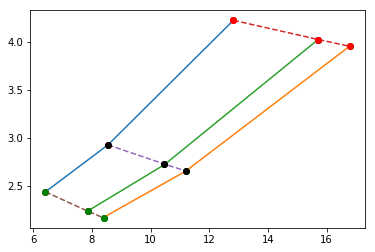

no_var        m              b
t6 1.408929637636848 1.089368733590056
t4 1.2475193794157555 1.0773675408006573
t7 1.1952442389507707 1.0738651616795112


In [46]:
def let(x,m,c): return m*c**x 
a=[c2,c3,c4];aa=[cc2,cc3,cc4];aaa=[ccc2,ccc3,ccc4]; b=np.array([t6/0.2,t6/0.3,t6/0.4]);bb=np.array([t7/0.2,t7/0.3,t7/0.4]); bbb=np.array([t4/0.2,t4/0.3,t4/0.4])
fi=op.curve_fit(let,b,a); ma,ca=fi[0]
fi2=op.curve_fit(let,bb,aa) ; mma,cca=fi2[0]
fi3=op.curve_fit(let,bbb,aaa) ; mmma,ccca=fi3[0]
plt.plot(b,a,"ro")  ; plt.plot(b,let(b,ma,ca))
plt.plot(bb,aa,"go") ; plt.plot(bb,let(bb,mma,cca))
plt.plot(bbb,aaa,"ko") ; plt.plot(bbb,let(bbb,mmma,ccca))
caso2_y_2=[c2,ccc2,cc2] ; caso2_x_2=np.array([t6/0.2,t4/0.2,t7/0.2])
caso2_y_3=[c3,ccc3,cc3] ; caso2_x_3=np.array([t6/0.3,t4/0.3,t7/0.3])
caso2_y_4=[c4,ccc4,cc4] ; caso2_x_4=np.array([t6/0.4,t4/0.4,t7/0.4])
def rec(x,m,b): return m*b**x
fitt_2=op.curve_fit(rec,caso2_x_2,caso2_y_2) ; md,bd=fitt_2[0]
plt.plot(caso2_x_2,rec(caso2_x_2,md,bd),"--")

fitt_3=op.curve_fit(rec,caso2_x_3,caso2_y_3) ; md3,bd3=fitt_3[0]
plt.plot(caso2_x_3,rec(caso2_x_3,md3,bd3),"--")

fitt_4=op.curve_fit(rec,caso2_x_4,caso2_y_4) ; md4,bd4=fitt_4[0]
plt.plot(caso2_x_4,rec(caso2_x_4,md4,bd4),"--")

plt.plot(caso2_x_2,caso2_y_2,"ro")
plt.plot(caso2_x_4,caso2_y_4,"go")
plt.plot(caso2_x_3,caso2_y_3,"ko")
plt.show()
print("no_var","       m","             b")
print("t6",ma,ca)
print("t4",mmma,ccca)
print("t7",mma,cca)


[ 2.49750626 -0.60745661] [0.02060302 0.00757286]


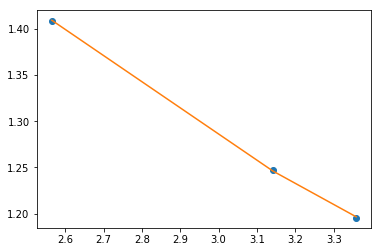

In [47]:
tt=np.array([1.408929637636848,1.2475193794157555,1.1952442389507707]) ; hk=[t6,t4,t7]
def cua(x,m,c): return m* x**(c)
fl=op.curve_fit(cua,hk,tt); mf,cf=fl[0]
print(fl[0],np.sqrt(np.diag(fl[1])))
plt.plot(hk,tt,"o")
plt.plot(hk,cua(hk,mf,cf))

[ 1.14566225 -0.05353341] [0.00146375 0.00115729]


6.196294377095777e-08

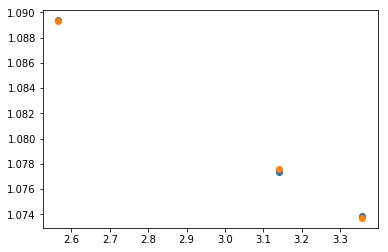

In [48]:
lf=np.array([1.089368733590056,1.0773675408006573,1.0738651616795112]) ; hk=np.array([t6,t4,t7])
def cua(x,m,c): return m*x**c
fl=op.curve_fit(cua,hk,lf); mf,cf=fl[0]
print(fl[0],np.sqrt(np.diag(fl[1])))
plt.plot(hk,lf,"o")
plt.plot(hk,cua(hk,mf,cf),"o")
chiq=sum( (lf-cua(hk,mf,cf))**2 )
chiq

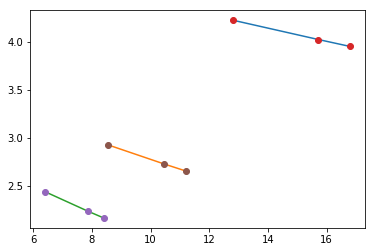

0.2 5.232749017671005 0.9834209096775327
0.3 4.006650107006349 0.9639727253346879
0.4 3.5683202178824613 0.9424168290527166


In [49]:
caso2_y_2=[c2,ccc2,cc2] ; caso2_x_2=np.array([t6/0.2,t4/0.2,t7/0.2])
caso2_y_3=[c3,ccc3,cc3] ; caso2_x_3=np.array([t6/0.3,t4/0.3,t7/0.3])
caso2_y_4=[c4,ccc4,cc4] ; caso2_x_4=np.array([t6/0.4,t4/0.4,t7/0.4])
def rec(x,m,b): return m*b**x
fitt_2=op.curve_fit(rec,caso2_x_2,caso2_y_2) ; md,bd=fitt_2[0]
plt.plot(caso2_x_2,rec(caso2_x_2,md,bd))
fitt_3=op.curve_fit(rec,caso2_x_3,caso2_y_3) ; md3,bd3=fitt_3[0]
plt.plot(caso2_x_3,rec(caso2_x_3,md3,bd3))
fitt_4=op.curve_fit(rec,caso2_x_4,caso2_y_4) ; md4,bd4=fitt_4[0]
plt.plot(caso2_x_4,rec(caso2_x_4,md4,bd4))
plt.plot(caso2_x_2,caso2_y_2,"o")
plt.plot(caso2_x_4,caso2_y_4,"o")
plt.plot(caso2_x_3,caso2_y_3,"o")
plt.show()
print("0.2",md,bd)
print("0.3",md3,bd3)
print("0.4",md4,bd4)
#md-md3, md3-md4, (md-md4)/2   #1.2-2*alpha


(array([1.02660362, 0.80834987]), 0.9428498589945962)

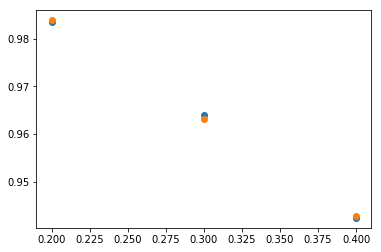

In [50]:
gr=np.array([0.9834209096775327,0.9639727253346879,0.9424168290527166]) ; alj=np.array([0.2,0.3,0.4])
def lik(x,m,b): return m*b**x
ji=op.curve_fit(lik,alj,gr); m,b=ji[0]
plt.plot(alj,gr,"o")
plt.plot(alj,lik(alj,m,b),"o")
ji[0], 1.02660362* 0.80834987**(0.4)

In [51]:
#to=t6 ; al=0.2 ;ff= 1.635 ; h=-0.3421; c=1.075 ; x=to/al #0.3---1.05, 0.4--1 
#( (ff*x)/(x-1) )*(c**x)+ h*al*x  , c2 
mf*(0.2**cf)#,mf*(0.2**cf)mf*(0.2**cf)

1.2487481414555819

[ 2.06427922 -0.57357665] [0.18696681 0.06631007]


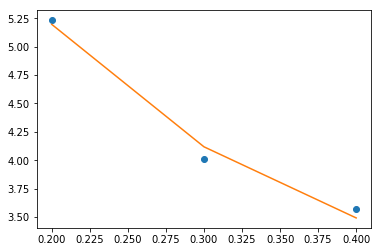

In [52]:
al=np.array([5.232749017671005,4.006650107006349,3.5683202178824613 ])
def cua(x,m,c): return m* x**(c)
fl=op.curve_fit(cua,ppp,al); mf,cf=fl[0]
print(fl[0],np.sqrt(np.diag(fl[1])))
plt.plot(ppp,al,"o")
plt.plot(ppp,cua(ppp,mf,cf))

### variacion de C- Energia

In [53]:
a2=6/(6*(0.2**2)); a3=6/(6*(0.3**2)); a4=6/(6*(0.4**2)) #muy interesante
j2=24.16457561/a2;j3=10.11958652/a3 ; j4=5.38414657/a4
print(j2),print(j3),print(j4)
j2-j3,j3-j4,j2-j4  #, (1-0.9665830244000001)/(0.2), (1-0.9107627868000001)/0.3, (1-0.8614634512000002)/0.4

0.9665830244000001
0.9107627868000001
0.8614634512000002


(0.05582023759999999, 0.04929933559999988, 0.10511957319999987)

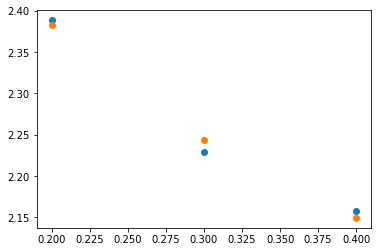

(array([ 1.87530444, -0.14881736]), array([0.03840149, 0.01576003]))

In [54]:
enf=np.array([2.3884,2.229,2.158]) ; ap=np.array([0.2,0.3,0.4])
def lit(x,m,b): return m* x**b
hfi=op.curve_fit(lit,ap,enf)
m,b=hfi[0]
plt.plot(ap,enf,"o")
plt.plot(ap,lit(ap,m,b),"o")
plt.show()
hfi[0], np.sqrt(np.diag(hfi[1]))

In [57]:
t6*0.2, t6*0.3, t6*0.4, t6*0.1, a3-10.11958652

(0.5130199320647456,
 0.7695298980971185,
 1.0260398641294912,
 0.2565099660323728,
 0.9915245911111104)

In [58]:
k=7; h=j2**(1/0.2)*t6; l=2.02; alj=0.4 ;E=a4; to=t6
(h/to)**(alj*h) *E

def E_c(k,m,alpha): #2.158   #642132971660155   1.87530444, -0.14881736
    E_a=k/(6*(alpha**2)) ; To=(2*np.pi)/(np.sqrt(k/m)) ; h=  (1.87)*( alpha**(-0.15) )
    return (h/To)**(h*alpha) *E_a

E_c(7,2,0.3)

9.874408646437852

In [59]:
aa2=7/(6*(0.2**2)); aa3=7/(6*(0.3**2));aa4=7/(6*(0.4**2))
jj2=23.89488232/aa2 ; jj3=9.85003055/aa3 ;jj4= 5.11476051/aa4
print(jj2),print(jj3),print(jj4)
jj2-jj3, jj3-jj4, jj2-jj4

0.8192531081142859
0.7598594995714286
0.7014528699428573


(0.059393608542857246, 0.05840662962857135, 0.1178002381714286)

In [60]:
aaa2=4/(6*(0.2**2)); aaa3=4/(6*(0.3**2));aaa4=4/(6*(0.4**2))
jjj2=23.96179015/aaa2;jjj3= 9.9167147/aaa3;jjj4= 5.18149008/aaa4
print(jjj2), print(jjj3), print(jjj4)
jjj2-jjj3, jjj3-jjj4, jjj2-jjj4

1.4377074090000002
1.3387564845000002
1.2435576192000002


(0.09895092449999998, 0.09519886529999999, 0.19414978979999997)

In [61]:
t6=(2*np.pi)/(np.sqrt(6/1));t7=(2*np.pi)/(np.sqrt(7/2)); t4=(2*np.pi)/(np.sqrt(4/1))
t6,t7,t4

(2.565099660323728, 3.358503816725428, 3.141592653589793)

### variación de b- periodo 

In [62]:
t_2=2.60448111/t6; t_3=2.52712027/t6;t_4= 2.47859983/t6 
print(t_2),print(t_3),print(t_4) 
t_2 -t_3, t_3-t_4, t_2-t_4 

1.015352795170267
0.985193795425892
0.9662781794946667


(0.03015899974437497, 0.01891561593122537, 0.04907461567560034)

In [63]:
(0.90439867)*((0.4)**(-0.07171358)) *(t4)

3.034222960040362

(array([ 0.90439867, -0.07171358]), array([0.00223589, 0.00192107]))

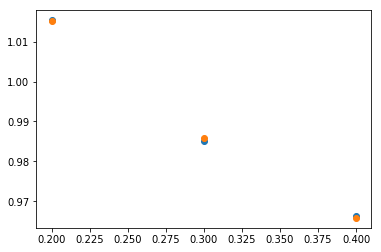

In [64]:
fg=np.array([t_2,t_3,t_4]) ; al=np.array([0.2,0.3,0.4])
def lk(x,m,b): return m* x**b
lo=op.curve_fit(lk,al,fg)
m,b=lo[0]
plt.plot(al,fg,"o")
plt.plot(al,lk(al,m,b),"o")
lo[0], np.sqrt(np.diag(lo[1]))

In [65]:
def T_o(to,alpha): 
    ñ=0.0156
    return (1- 10*(alpha-0.3)*ñ )*to

T_o(t6,0.2)

2.6051152150247785

In [66]:
tt_2=3.41013082/t7; tt_3=3.30886218/t7; tt_4=3.24515864/t7
print(tt_2),print(tt_3),print(tt_4) 
tt_2-tt_3, tt_3-tt_4, tt_2-tt_4

1.015372024595437
0.9852191215391177
0.9662512883978377


(0.030152903056319236, 0.018967833141280033, 0.04912073619759927)

In [67]:
3.41013082-t7, 3.30886218-t7, 3.24515864-t7

(0.051627003274572036, -0.04964163672542776, -0.11334517672542788)

In [68]:
(1-1*0.014644077114202)*(t7) #cuidado

3.309321627844959

In [69]:
ttt_2=3.18981102/t4; ttt_3=3.09519149/t4; ttt_4=3.03570215/t4 
print(ttt_2),print(ttt_3),print(ttt_4) 
ttt_2-ttt_3, ttt_3-ttt_4, ttt_2-ttt_4

1.0153483827240013
0.9852300508989374
0.9662940058543887


(0.03011833182506385, 0.01893604504454871, 0.04905437686961256)

In [70]:
def Aprox_T_M1(k,m,alpha,A):
    to=(2*np.pi)/(np.sqrt(k/m)) ;    E_a= k/(6*(alpha**2))    ;   phi=(0.91)*((alpha)**(-0.071)) 
    h=(1.87)*( alpha**(-0.15) ) ;    c=(h/to)**(h*alpha)* E_a ;   b=phi*to
    a1= ( (2.15787867)*((to)**(-0.69389621)) )* (alpha)**(-(0.60176868* (to)**0.32827483))
    a2= ( (2.16)*((to)**(-0.69)) )* (alpha)**(-(0.602* (to)**0.33))
    
    return np.exp(A**2 - c) + np.exp(A-a2) + b#, np.exp(A**2 - c) + np.exp(A-a2) + b  

In [161]:
alpha=0.2; k=6 ; m=1 ; A=3
Aprox_T_M1(k,m,alpha,A) , Apox_M1_2(alpha,k,m,A) ,OscAnar1(rk4,k,m,A,0,alpha,0,5*np.pi,1e-3)[1][0] #6,1,2,0.2

(2.909029345007063, 2.95317277659237, 2.9495908783703992)

## Oscilador anarmonico - Segundo modelo

In [72]:
def OscAnar2(Integrador,Cnste_Elastica,Masa,Amplitud,Desfase,Power,to,tf,h,Graficas=False):
    k= Cnste_Elastica; m= Masa; A= Amplitud; phi= Desfase; p= Power; w= np.sqrt(k/m)
    
    #Condiciones iniciales 
    xo=np.array([A*np.cos(phi),-A*w*np.sin(phi)])
    
    n=int((tf-to)/h); t=np.linspace(to,tf,n); x=np.zeros([len(t),2]); x[0]=xo
    
    #Función vectorial (derivadas, dx/dt, dv/dt)
    def f1(t,y,w=w,p=p): return np.array([y[1],-w**2 *y[0]**(p-1)])
    
    #Funcion para encontrar el periodo 
    def periodo(z,t):
        top=[] ;  periodos=[]
        for i in range(1,len(t)):
            if z[i,0]*z[i-1,0] < 0: to= 0.5*(t[i-1] + t[i]) ; top= np.hstack((top,to))    
             
        for i in range(len(top)-2): Tp= top[i+2]-top[i] ; periodos = np.hstack((periodos,Tp))
            
        if len(periodos) < 1: return 0.0, "No suficientes tiempo, para encontrar el periodo"  
        
        return periodos.mean(), periodos.std()
    
    z=Integrador(f1,x,t,h)  #posiciones y velocidades   
    T=periodo(z,t)
    
    # Energia Mecanica del sistema
    K= 0.5*m*(z[:,1]**2)  ;  V= (1/p)*k*(z[:,0])**(p)  ;  ET= K + V
    
    if Graficas != False:
        
        plt.plot(t,z[:,0],t,z[:,1]), plt.legend(("Posición","Velocidad")), plt.grid(),plt.xlabel("Tiempo")
        plt.ylabel("Y (t)"),plt.title("Vector dinámico vs tiempo, Modelo 2");plt.show() # grafica 1
    
        plt.plot(t,ET,"k--",t,K,t,V),plt.legend(("E-total","K","V")), plt.grid(),plt.xlabel("Tiempo") 
        plt.ylabel("Energía"),plt.title("Energías vs tiempo, Modelo 2");plt.show() #grafica 2
    
        plt.plot(z[:,0],V,label="V(x) vs x"),plt.xlim(-2*A,2*A), plt.legend(),plt.grid()
        plt.xlabel("x"),plt.title("Pozo de potencial, Modelo 2");plt.show() #grafica 3
    
    return "Periodo = ",T,"Posiciones(t) = ",z[:,0],"Velocidades(t) = ",z[:,1] 

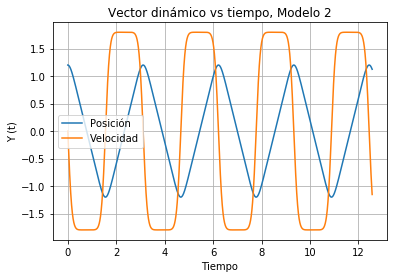

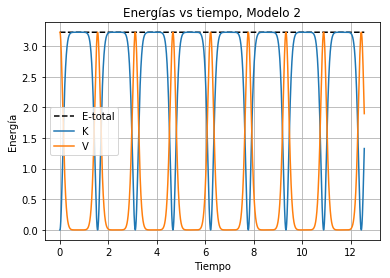

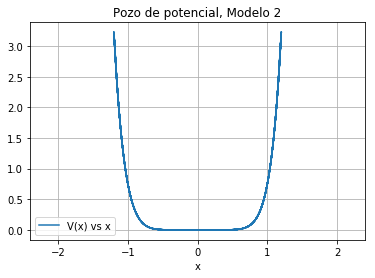

('Periodo = ',
 (3.110672614473682, 0.0004714559425020663),
 'Posiciones(t) = ',
 array([1.2       , 1.19999463, 1.1999785 , ..., 1.12532131, 1.12417942,
        1.12303072]),
 'Velocidades(t) = ',
 array([-0.        , -0.01074943, -0.02149819, ..., -1.13847401,
        -1.14530551, -1.15208848]))

In [73]:
OscAnar2(rk4,6,2,1.2,0,8,0,4*np.pi,1e-3,Graficas=True) #6,2,1.2,8

In [74]:
def Graficas_amplitudes_M2(to,tf,h,A1=0.9,A2=1.1,A3=1.8,p=8):
    n=int((tf-to)/h)  ; t=np.linspace(to,tf,n)
    g1=OscAnar2(rk4,6,1,A1,0,p,to,tf,h)   ;  g2=OscAnar2(rk4,6,1,A2,0,p,to,tf,h)
    g3=OscAnar2(rk4,6,1,A3,0,p,to,tf,h)
    
    plt.plot(t,g1[3],linewidth=3)  ; plt.plot(t,g2[3],"r-.",linewidth=2)
    plt.plot(t,g3[3],"k--",linewidth=1)
    
    plt.legend(("A1","A2","A3")) , plt.grid() , plt.xlabel("Tiempo") , plt.ylabel("Posicion (t)")
    plt.title("Dependencia de la amplitud, p=8");plt.show()
    
    return "T1, T2, T3 =",g1[1][0],g2[1][0],g3[1][0]

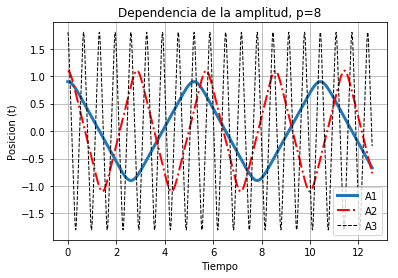

('T1, T2, T3 =', 5.213568644063221, 2.8555971743413875, 0.6516927017610042)

In [75]:
Graficas_amplitudes_M2(0,4*np.pi,1e-3)

In [76]:
def P_Am_M2(Ao,Af,particiones,to=0,tf=9*np.pi,h=1e-3,p=6,k=6,m=1):
    #observación
    Amplitudes=np.linspace(Ao,Af,particiones)   ;    Periodos=[]
    for i in range(len(Amplitudes)):
        A= Amplitudes[i] ;  po=OscAnar2(rk4,k,m,A,0,p,to,tf,h)[1][0] ; Periodos= np.hstack((Periodos,po))
    #Ajuste  
    def f(x,a,b): return a/(x**b) #+ b/x
    data=op.curve_fit(f,Amplitudes,Periodos) ; a,b=data[0] ; sigma=np.sqrt(np.diag(data[1]))
    
    chiq=sum( (Periodos-f(Amplitudes,a,b))**2 ) ; af=np.array([a,sigma[0]]) ; bf=np.array([b,sigma[1]]) 
    
    #grafica
    plt.plot(Amplitudes,Periodos,"k."),plt.plot(Amplitudes,f(Amplitudes,a,b))
    plt.grid(), plt.title("Periodo vs Amplitud, Modelo 2"),plt.xlabel("Amplitud (A)"),plt.ylabel("Periodo (T)")
    plt.legend(("T vs A","T(x) = a $x^{-b}$ "))  ;plt.show()
    
    #def Aprox_T_M2(p,k,m,A):
     #   n=(p-2)/2;To=(2*np.pi)/(np.sqrt(k/m)); landa= (0.2)*(0.974**p) 
      #  return (1+n*landa)*To*(A**(-n))

    #plt.plot(Amplitudes,Aprox_T_M2(p,k,m,Amplitudes));plt.savefig("idea.svg")

    return "a=",af,"b=",bf,"chiq=",chiq

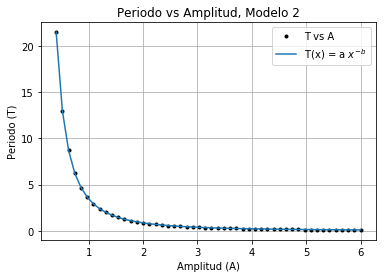

('a=',
 array([3.43478465e+00, 9.16832159e-06]),
 'b=',
 array([2.00002721e+00, 3.43696065e-06]),
 'chiq=',
 4.679216417797495e-08)

In [77]:
P_Am_M2(0.4,6,50)

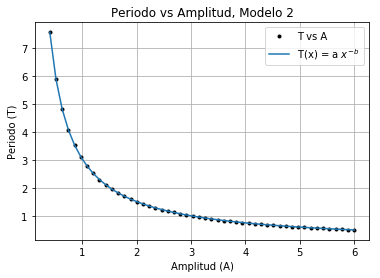

('a=',
 array([3.02798123e+00, 1.51672828e-05]),
 'b=',
 array([9.99985427e-01, 6.95264584e-06]),
 'chiq=',
 2.3644383609610678e-07)

In [78]:
P_Am_M2(0.4,6,50,p=4,tf=4*np.pi)

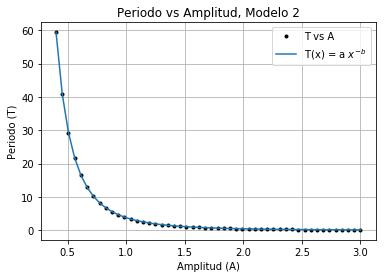

('a=',
 array([3.80032536e+00, 1.84344514e-05]),
 'b=',
 array([3.00001777e+00, 6.06113673e-06]),
 'chiq=',
 4.936566364957039e-07)

In [79]:
P_Am_M2(0.4,3,50,p=8,tf=25*np.pi)

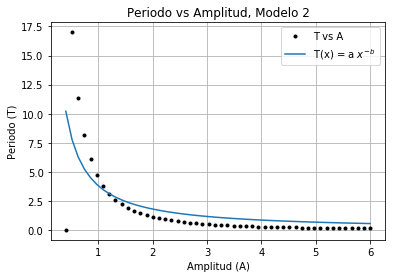

('a=',
 array([3.79191076, 0.49561776]),
 'b=',
 array([1.08055768, 0.18355218]),
 'chiq=',
 240.95024005462142)

In [80]:
P_Am_M2(0.4,6,50,k=7,m=2)

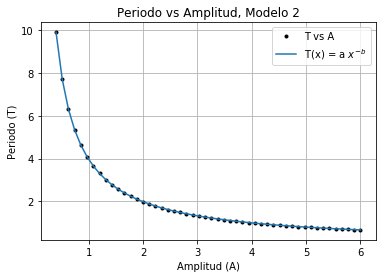

('a=',
 array([3.96435776e+00, 5.96080048e-06]),
 'b=',
 array([1.00000142e+00, 2.08702936e-06]),
 'chiq=',
 3.6518934795271574e-08)

In [81]:
P_Am_M2(0.4,6,50,k=7,m=2,p=4)

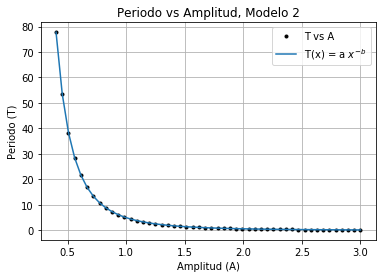

('a=',
 array([4.97578997e+00, 5.37628281e-06]),
 'b=',
 array([3.00000466e+00, 1.35009739e-06]),
 'chiq=',
 4.1988017136643203e-08)

In [82]:
P_Am_M2(0.4,3,50,p=8,tf=31*np.pi,k=7,m=2)

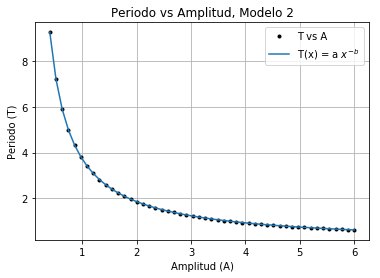

('a=',
 array([3.70852685e+00, 1.92183099e-05]),
 'b=',
 array([9.99981825e-01, 7.19298194e-06]),
 'chiq=',
 3.7961520534712874e-07)

In [83]:
P_Am_M2(0.4,6,50,k=4,m=1,p=4,tf=4*np.pi)

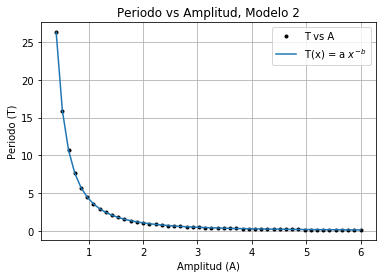

('a=',
 array([4.20669327e+00, 1.61154487e-05]),
 'b=',
 array([2.00000770e+00, 4.93272433e-06]),
 'chiq=',
 1.4457056895842786e-07)

In [84]:
P_Am_M2(0.4,6,50,k=4,m=1,p=6,tf=11*np.pi)

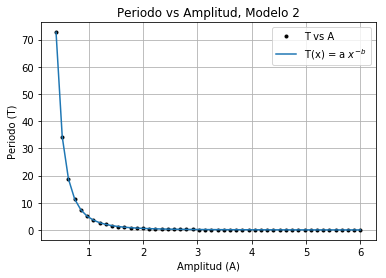

('a=',
 array([4.65481493e+00, 2.56066530e-03]),
 'b=',
 array([2.99990100e+00, 6.50128048e-04]),
 'chiq=',
 0.004750908608590819)

In [85]:
P_Am_M2(0.4,6,50,k=4,m=1,p=8,tf=30*np.pi)

In [86]:
aa=np.sqrt(7/2); bb= (2*np.pi/aa); dd=np.sqrt(6/1) ;cc=(2*np.pi/dd); ee=np.sqrt(4/1) ; ff=(2*np.pi/ee)
bb,cc,ff

(3.358503816725428, 2.565099660323728, 3.141592653589793)

In [155]:
a6_4/t6,  a7_4/t7, a4_4/t4

(1.180453639613306, 1.180386152982032, 1.1804607595330319)

(array([ 1.19644263, -0.01616779]), array([0.00459936, 0.00141921]))

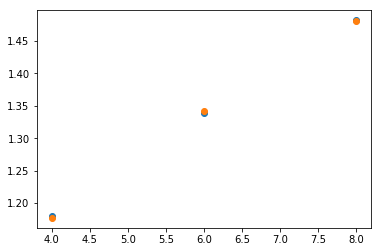

In [87]:
a6_6=3.43478465 ; a6_4=3.02798123 ; a6_8=3.80032536
a7_6=4.49718491 ; a7_4=3.96433140 ; a7_8=4.97578997
a4_6=4.20669327 ; a4_4=3.70852685 ; a4_8=4.65481493

a4=(a6_4/t6+ a7_4/t7+a4_4/t4)/3 ; a6=(a6_6/t6+ a7_6/t7+a4_6/t4)/3 ; a8=(a6_8/t6+ a7_8/t7+a4_8/t4)/3  
jk=np.array([a4,a6,a8]) ; pl=np.array([4,6,8])
def re(x,a,b): return (a*np.exp(b*(x-2)/2))**((x-2)/2)  #a* b**((x-2)/2)
fil=op.curve_fit(re,pl,jk); a,b=fil[0]
plt.plot(pl,jk,"o")
plt.plot(pl,re(pl,a,b),"o")
fil[0], np.sqrt(np.diag(fil[1]))

In [146]:
def Apro_M2_2(p,k,m,A):
    n=(p-2)/2 ; to=(2*np.pi)/(np.sqrt(k/m))
    a1= 1.19644263; b1= -0.01616779
    return (a1*np.exp(b1*n))**n *to* A**(-n)

In [147]:
p=4;k=8; m=5; A=3
Apro_M2_2(p,k,m,A),Aprox_T_M2(p,k,m,A),OscAnar2(rk4,k,m,A,0,p,0,4*np.pi,1e-3)[1][0] 

(1.949256177076487, 1.9537977734571617, 1.9545768221068158)

In [92]:
j_t7_p4=3.96433140/bb #p=4
j_t7_p4

1.180386152982032

In [93]:
j_t6_p4=3.02798123/cc #p4
j_t6_p4

1.180453639613306

In [94]:
j_t7_p6=4.49718491/bb #p6
j_t7_p6

1.3390441563900906

In [95]:
j_t6_p6=3.43476203/cc #p6
j_t6_p6

1.339036483894944

In [96]:
j_t7_p8=4.97578997/bb #p8
j_t7_p8

1.4815495951561672

In [97]:
j_t6_p8=3.80032536/cc #p8
j_t6_p8

1.4815507634196092

In [98]:
j_t4_p4=3.70852685/ff #p4
j_t4_p4

1.1804607595330319

In [99]:
j_t4_p6=4.20669327/ff #p6
j_t4_p6

1.3390320559838182

In [100]:
j_t4_p8=4.65481493/ff #p8
j_t4_p8

1.4816736105749095

In [101]:
1.3390441563900906-1.180386152982032

0.15865800340805847

In [102]:
1.4815495951561672-1.3390441563900906 , 1.4815495951561672-1.180386152982032

(0.1425054387660767, 0.30116344217413515)

In [103]:
1.180386152982032-0.15865800340805847

1.0217281495739736

In [104]:
1.0217281495739736 + 3*0.154

1.4837281495739736

In [105]:
( (j_t6_p8-j_t6_p6)+(j_t6_p6-j_t6_p4)+((j_t6_p8-j_t6_p4)/2) + \
(j_t4_p8-j_t4_p6)+(j_t4_p6-j_t4_p4)+((j_t4_p8-j_t4_p4)/2) + \
(j_t7_p8-j_t7_p6)+(j_t7_p6-j_t7_p4)+((j_t7_p8-j_t7_p4)/2) )/9

0.15057890283705266

In [106]:
to=(2*np.pi)/(np.sqrt(7/3)); i=0.16; p=8; A=2
to

4.113310325083545

In [107]:
n=(p-2)/2
( 1 + n*i)*to*(A**(-n))

0.7609624101404558

In [108]:
def Aprox_T_M2(p,k,m,A):
    n=(p-2)/2;To=(2*np.pi)/(np.sqrt(k/m)); landa= (0.2)*(0.974**p) #(0.19897377)*(0.97429914**p) 
    return (1+n*landa)*To*(A**(-n))

In [109]:
p=2;k=6; m=3; A=5
Aprox_T_M2(p,k,m,A) , OscAnar2(rk4,k,m,A,0,p,0,4*np.pi,1e-3)[1][0] 

(4.442882938158366, 4.443234623712234)

In [110]:
p=6;k=6; m=2; A=8
Aprox_T_M2(p,k,m,A) , OscAnar2(rk4,k,m,A,0,p,0,4*np.pi,1e-3)[1][0] 

(0.07603889646249294, 0.07595357301191936)

In [113]:
li(12,mi,bi)

0.14558065936953146

[0.19897377 0.97429914] [0.0017171  0.00103948]


4.700890636936089e-06

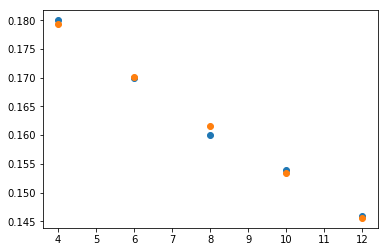

In [112]:
alp=np.array([0.18,0.17,0.16,0.154,0.146]); P=np.array([4,6,8,10,12])
def li(x,m,b): return m*b**x 
lk=op.curve_fit(li,P,alp)
mi,bi=lk[0]
plt.plot(P,alp,"o")
plt.plot(P,li(P,mi,bi),"o")
print(lk[0], np.sqrt(np.diag(lk[1])))
chiq=sum( (alp-li(P,0.2,0.974))**2 )
chiq